<h1><b><center>Skin Cancer(HAM10000) Project Report <br> Tahmeed Anjum Hossain <br> 190520304
</center>
</b></h1>
<h2><b>Table of Contents</b></h2>

<ol>
  <li>Introduction </li>
   <li>Resources and Data</li> 
   <li>Project objectives & planning </li>
   <li>EDA </li>
  <li>Image Processing</li> 
  <li>Key findings</li>   
</ol>

<h4>1. Introduction</h4>
<p> Early detection of conditions of skin cancer is 
very crucial thus pigment skin diagnosis field has been growing
rapidly. Recently various kinds of detection methods
and the computerised algorithm is used to improve the accuracy
of detection.</p>

<h4>2. Resource and data</h4>
<p> The dataset is collected from a competition in Kaggle. 
  <a href="https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000"> It can be collected from here.</a>
  Although the dataset was first made publicly available by the Harvard Database
  on June,2018. The main target was to provide training data so that the process 
  of skin cancer lesion classification can be automated. If successful, the application
  can be helpful for medical professionals. It will also reduce cost and save time.
  Other than 10,015 images, a metadata file including demographic information of each lesion is provided as well.
  The 7 classes of skin cancer lesions included in this dataset are:
  
  
<ol> <li>Melanocytic nevi</li>
    <li>Melanoma </li>
  <li>Benign keratosis-like lesions</li>
    
  <li>Basal cell carcinoma</li>
<li> Actinic keratoses</li>
<li> Vascular lesions </li>
<li> Dermatofibroma </li></p>
</ol>
<h4>3. Project objective & planning</h4>

<p>For this specific dataset, computation time is more important than getting a higher accuracy. As for cancer, it is crucial to detect the disease at early stage, which means dataset of large population need to be processed as quickly as possible. In this primary level, accuracy is calculated between lower resolution model and higher resolution by keeping the computation time factor in mind.</p>
<h4>4. Exploratory data analysis</h4>
<p> At first necessary library is installed 
  for the project. </p>

In [320]:
import numpy as np
import pandas as pd
import imageio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
import skimage
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from tqdm import tqdm
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler

!pip install keras
import keras

from PIL import Image


In [321]:
!pip install tensorflow
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Reshape, Conv2D, MaxPool2D, concatenate, Activation, Dropout
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential, load_model
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [322]:
!pip install imblearn

In [323]:
!pip install scipy

In [324]:
from imblearn.under_sampling import RandomUnderSampler

<p> EDA process starts from here by loading the data in the jupyter notebook </p>

In [325]:
# importing data
metadata = pd.read_csv('/Users/ragnar/Downloads/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [326]:
print(metadata.shape)

(10015, 7)


In [327]:
# encoded label for all the seven class

le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print(list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
5844,HAM_0000400,ISIC_0031414,nv,follow_up,45.0,male,upper extremity,5
9853,HAM_0005650,ISIC_0030387,akiec,histo,65.0,male,lower extremity,0
2261,HAM_0002131,ISIC_0030901,mel,histo,55.0,male,upper extremity,4
7428,HAM_0006857,ISIC_0033475,nv,histo,40.0,female,back,5
3302,HAM_0006845,ISIC_0030170,nv,follow_up,45.0,female,upper extremity,5
2855,HAM_0006588,ISIC_0031552,bcc,histo,70.0,female,face,1
9687,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,0
1001,HAM_0003668,ISIC_0024383,bkl,consensus,70.0,female,trunk,2
8578,HAM_0003562,ISIC_0030544,nv,histo,60.0,female,face,5
3103,HAM_0000408,ISIC_0027000,nv,follow_up,45.0,female,lower extremity,5


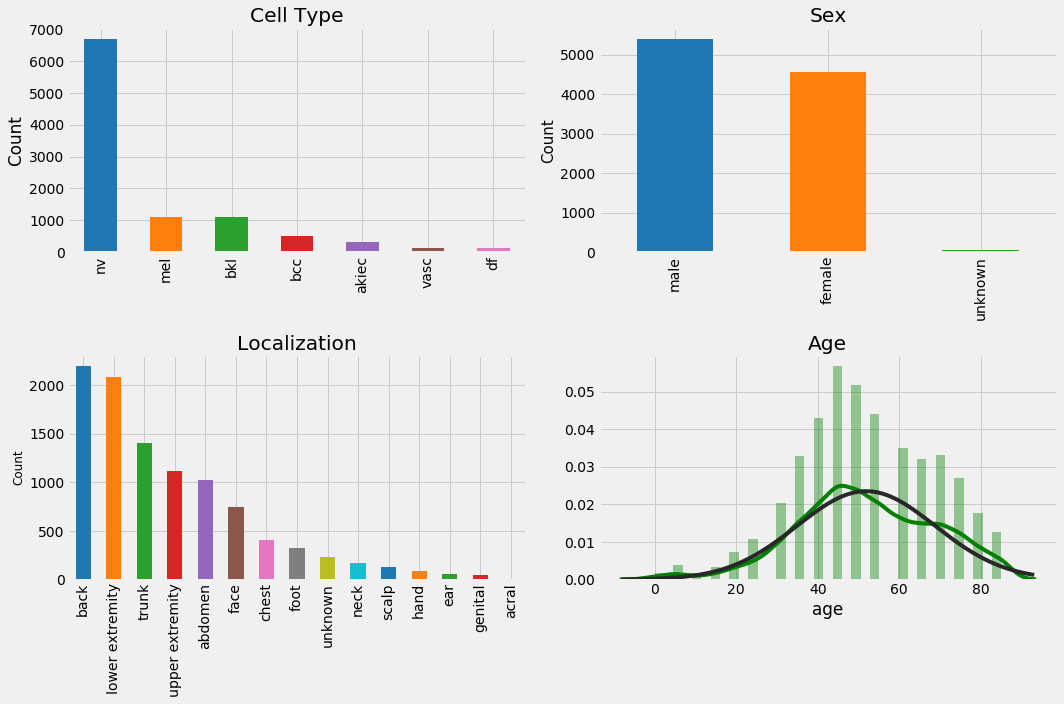

In [328]:
# glimpse of distribution from each column

fig = plt.figure(figsize=(15,10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

g1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=g1, color=colors)
g1.set_ylabel('Count')
g1.set_title('Cell Type');

g2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=g2, color=colors)
g2.set_ylabel('Count', size=15)
g2.set_title('Sex');

g3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar', color=colors)
g3.set_ylabel('Count',size=12)
g3.set_title('Localization')


g4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='green');
g4.set_title('Age')

plt.tight_layout()
plt.show()

<h4>5. Image processing</h4>
<p> At first, 28x28x3 images are analysed. </p>

In [329]:
image = pd.read_csv('/Users/ragnar/Downloads/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv', header=0)
featured_columns = image.columns[:-1]
featured_columns
image = image.drop(image.index[0])

In [330]:
display(image.shape, image.head())

(10014, 2353)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
5,8,1,3,19,5,10,26,8,13,34,...,12,3,7,5,0,1,4,0,0,2


In [331]:
# variable x & y are assigned for modelling
x = image[featured_columns]
y = image.label

In [332]:
x = np.asarray(x)/225
x = x.reshape(-1,28,28,3)
y = np.asarray(y)
print(x.shape, y.shape)

(10014, 28, 28, 3) (10014,)


In [333]:
# split into test dataset and train dataset

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x, y, test_size=0.4, stratify=y)
print(x_train_s.shape)
print(y_train_s.shape)
print(x_test_s.shape)
print(y_test_s.shape)

(6008, 28, 28, 3)
(6008,)
(4006, 28, 28, 3)
(4006,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

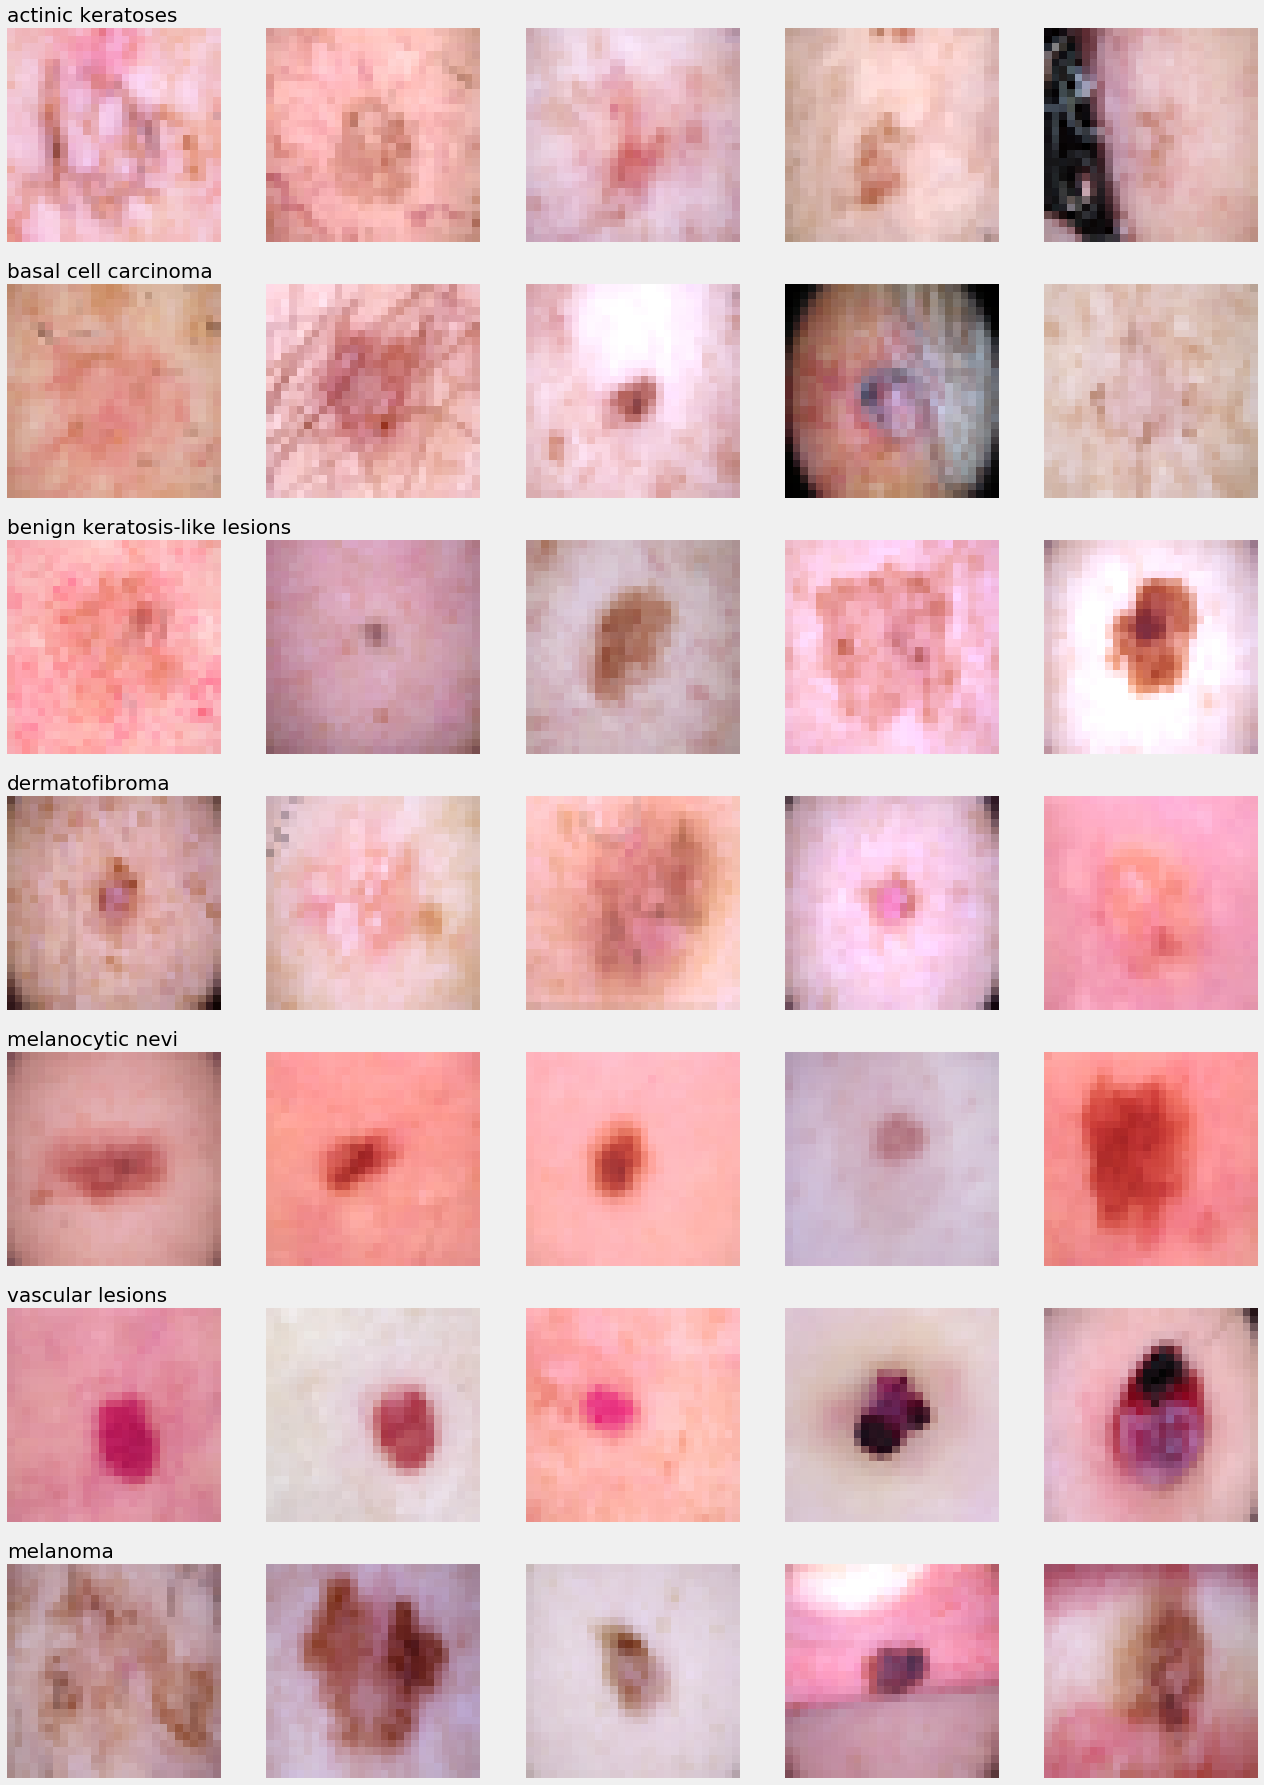

In [334]:
fig = plt.figure(figsize=(20, 30))
j=0
names = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions','dermatofibroma',
         'melanocytic nevi','vascular lesions','melanoma']

for class_number in range(7):
    
    example = x_train_s[np.where(y_train_s == class_number)][:5]

    for i, picture in enumerate(example):
        n=i+j
        picture.reshape(28,28,3)
        
        plt.subplot(7,5,n+1)
        plt.imshow(picture)
        if i ==0:
            plt.title(f'{names[class_number]}', size=20, loc='left')

        plt.axis('off')
    j+=5
plt.show()
fig.savefig('small_pix_sample.jpg')

<p> Running a simple architecture to see the baseline accuracy with smaller picture </p>

In [335]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(7))
model.add(Activation(tf.nn.softmax))


print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 128)             

In [336]:
#training model size: 28x28x3

y_test_s = to_categorical(y_test_s, num_classes=7)
y_train_s = to_categorical(y_train_s, num_classes=7)

In [337]:
model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['acc'])

history = model.fit(
    x_train_s, y_train_s,
    epochs=150,
    batch_size = 128,
    validation_data=(x_test_s, y_test_s),
    verbose=2)

Train on 6008 samples, validate on 4006 samples
Epoch 1/150
 - 2s - loss: 1.1881 - acc: 0.6566 - val_loss: 1.0159 - val_acc: 0.6695
Epoch 2/150
 - 2s - loss: 1.0100 - acc: 0.6696 - val_loss: 0.9906 - val_acc: 0.6695
Epoch 3/150
 - 2s - loss: 0.9519 - acc: 0.6714 - val_loss: 0.9178 - val_acc: 0.6697
Epoch 4/150
 - 2s - loss: 0.9243 - acc: 0.6681 - val_loss: 0.8798 - val_acc: 0.6792
Epoch 5/150
 - 2s - loss: 0.8983 - acc: 0.6841 - val_loss: 0.8536 - val_acc: 0.7007
Epoch 6/150
 - 2s - loss: 0.8963 - acc: 0.6791 - val_loss: 0.8585 - val_acc: 0.7047
Epoch 7/150
 - 2s - loss: 0.8704 - acc: 0.6904 - val_loss: 0.8243 - val_acc: 0.6997
Epoch 8/150
 - 2s - loss: 0.8527 - acc: 0.6921 - val_loss: 0.8226 - val_acc: 0.7127
Epoch 9/150
 - 2s - loss: 0.8338 - acc: 0.6939 - val_loss: 0.8536 - val_acc: 0.6875
Epoch 10/150
 - 2s - loss: 0.8236 - acc: 0.6972 - val_loss: 0.8009 - val_acc: 0.7254
Epoch 11/150
 - 2s - loss: 0.8045 - acc: 0.7044 - val_loss: 0.7900 - val_acc: 0.7079
Epoch 12/150
 - 2s - loss:

Epoch 97/150
 - 2s - loss: 0.0422 - acc: 0.9897 - val_loss: 1.6314 - val_acc: 0.7444
Epoch 98/150
 - 2s - loss: 0.0923 - acc: 0.9770 - val_loss: 1.6147 - val_acc: 0.7406
Epoch 99/150
 - 2s - loss: 0.0902 - acc: 0.9792 - val_loss: 1.6162 - val_acc: 0.7284
Epoch 100/150
 - 2s - loss: 0.1301 - acc: 0.9710 - val_loss: 1.5783 - val_acc: 0.7476
Epoch 101/150
 - 2s - loss: 0.0960 - acc: 0.9799 - val_loss: 1.6324 - val_acc: 0.7474
Epoch 102/150
 - 2s - loss: 0.0935 - acc: 0.9760 - val_loss: 3.1619 - val_acc: 0.6995
Epoch 103/150
 - 2s - loss: 0.1970 - acc: 0.9697 - val_loss: 1.6578 - val_acc: 0.7177
Epoch 104/150
 - 2s - loss: 0.0640 - acc: 0.9847 - val_loss: 1.6303 - val_acc: 0.7334
Epoch 105/150
 - 2s - loss: 0.1027 - acc: 0.9789 - val_loss: 1.6955 - val_acc: 0.7439
Epoch 106/150
 - 2s - loss: 0.1293 - acc: 0.9795 - val_loss: 1.5896 - val_acc: 0.7424
Epoch 107/150
 - 2s - loss: 0.1055 - acc: 0.9777 - val_loss: 1.5866 - val_acc: 0.7374
Epoch 108/150
 - 2s - loss: 0.0731 - acc: 0.9842 - val_lo

In [338]:
model.save('model_s.h5')

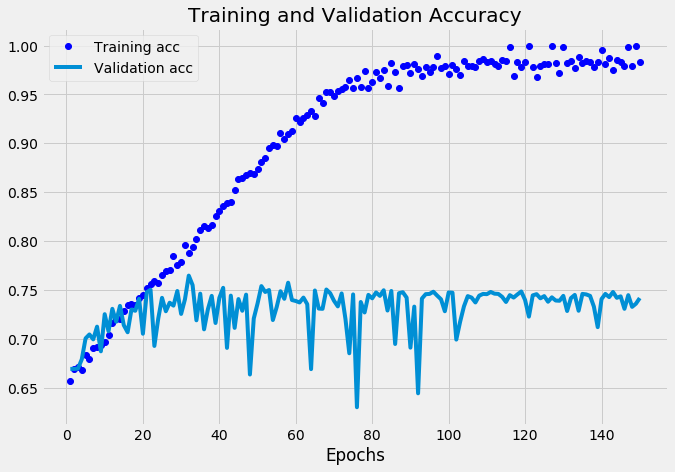

<Figure size 432x288 with 0 Axes>

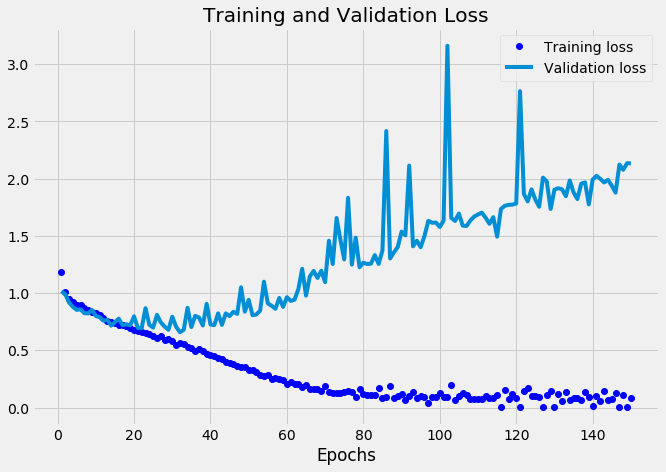

<Figure size 432x288 with 0 Axes>

In [339]:
fig = plt.figure(figsize=(10, 15))

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

In [340]:
y_predict_s = model.predict(x_test_s)

y_predict_classes_s = np.argmax(y_predict_s,axis = 1)
y_true = np.argmax(y_test_s,axis = 1) 
cm_1 = confusion_matrix(y_true,y_predict_classes_s)
cm_1

array([[  33,   32,   20,    3,   24,    0,   19],
       [  21,  104,   25,    3,   42,    0,   11],
       [  22,   34,  222,    1,  120,    0,   40],
       [   6,    9,    3,   13,   14,    0,    1],
       [  17,   30,  103,    4, 2431,    2,   95],
       [   1,    3,    2,    1,   16,   34,    0],
       [   7,    9,   59,    3,  231,    1,  135]])

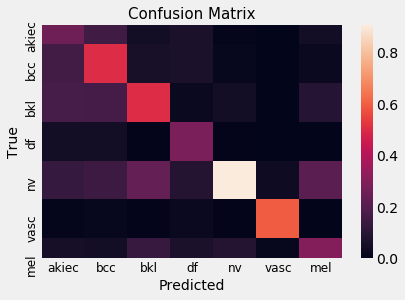

In [341]:
ax= plt.subplot()
sns.heatmap(cm_1 / cm_1.astype(np.float).sum(axis=1), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=14);
ax.set_ylabel('True', size=14); 
ax.set_title('Confusion Matrix', size=15); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'], size=12); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'],size=12);


In [342]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict_classes_s, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: 0.7240795960440264
recall: 0.7418871692461309
fscore: 0.7298312223209095


In [343]:
precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_predict_classes_s)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.30841121 0.47058824 0.51152074 0.46428571 0.84468381 0.91891892
 0.44850498]
recall: [0.2519084  0.50485437 0.50569476 0.2826087  0.90641312 0.59649123
 0.30337079]
fscore: [0.27731092 0.48711944 0.50859107 0.35135135 0.87446043 0.72340426
 0.36193029]


<p> Accuracy are high but outputs are unstable and there is sign of overfitting. Deterioation is significant after epoch 20. If epoch = 20,

In [344]:
model_1a = Sequential()

model_1a.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,3)))
model_1a.add(MaxPool2D((2, 2)))
model_1a.add(Conv2D(64, (3, 3), activation='relu'))
model_1a.add(MaxPool2D((2, 2)))
model_1a.add(Conv2D(128, (3, 3), activation='relu'))
model_1a.add(MaxPool2D((2, 2)))

model_1a.add(Flatten())

model_1a.add(Dense(512, activation='relu'))
model_1a.add(Dense(7))
model_1a.add(Activation(tf.nn.softmax))


#model = Model(inputs, outputs)
print(model_1a.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 128)             

In [345]:
model_1a.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['acc'])

history_1a = model_1a.fit(
    x_train_s, y_train_s,
    epochs=20,
    batch_size = 128,
    validation_data=(x_test_s, y_test_s),
    verbose=2)

Train on 6008 samples, validate on 4006 samples
Epoch 1/20
 - 2s - loss: 1.1145 - acc: 0.6556 - val_loss: 0.9759 - val_acc: 0.6695
Epoch 2/20
 - 2s - loss: 0.9862 - acc: 0.6696 - val_loss: 1.0585 - val_acc: 0.6568
Epoch 3/20
 - 2s - loss: 0.9483 - acc: 0.6721 - val_loss: 0.8862 - val_acc: 0.6822
Epoch 4/20
 - 2s - loss: 0.9146 - acc: 0.6751 - val_loss: 0.8814 - val_acc: 0.6742
Epoch 5/20
 - 2s - loss: 0.8909 - acc: 0.6816 - val_loss: 0.8502 - val_acc: 0.6945
Epoch 6/20
 - 2s - loss: 0.8786 - acc: 0.6871 - val_loss: 0.9289 - val_acc: 0.6907
Epoch 7/20
 - 2s - loss: 0.8575 - acc: 0.6906 - val_loss: 0.8346 - val_acc: 0.6987
Epoch 8/20
 - 2s - loss: 0.8386 - acc: 0.6959 - val_loss: 0.8443 - val_acc: 0.7004
Epoch 9/20
 - 2s - loss: 0.8156 - acc: 0.6986 - val_loss: 0.8270 - val_acc: 0.6820
Epoch 10/20
 - 2s - loss: 0.8037 - acc: 0.7034 - val_loss: 0.7777 - val_acc: 0.7132
Epoch 11/20
 - 2s - loss: 0.7820 - acc: 0.7172 - val_loss: 0.8380 - val_acc: 0.6895
Epoch 12/20
 - 2s - loss: 0.7683 - ac

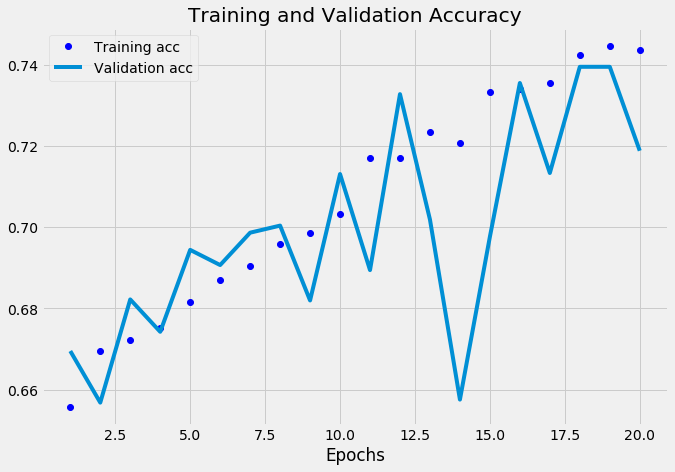

<Figure size 432x288 with 0 Axes>

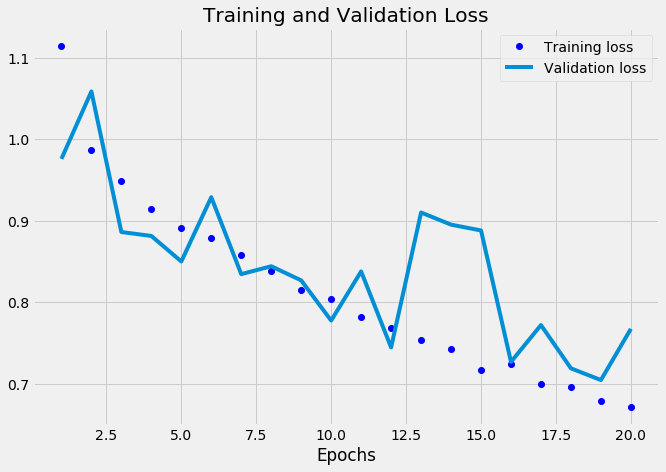

<Figure size 432x288 with 0 Axes>

In [346]:
fig = plt.figure(figsize=(10, 15))

accuracy = history_1a.history['acc']
val_accuracy = history_1a.history['val_acc']
loss = history_1a.history['loss']
val_loss = history_1a.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

In [347]:
y_predict_s = model_1a.predict(x_test_s)

y_predict_classes_s = np.argmax(y_predict_s,axis = 1)
y_true = np.argmax(y_test_s,axis = 1) 
cm_2 = confusion_matrix(y_true,y_predict_classes_s)
cm_2

array([[   5,   44,    5,    0,   68,    1,    8],
       [   3,   98,    6,    0,   93,    4,    2],
       [   6,   50,   72,    0,  297,    2,   12],
       [   3,   20,    3,    0,   19,    0,    1],
       [   1,   19,   10,    0, 2635,    8,    9],
       [   0,    4,    0,    0,   18,   34,    1],
       [   1,   14,    8,    0,  381,    5,   36]])

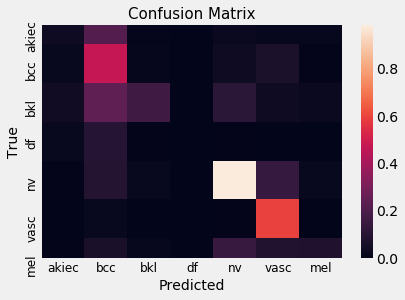

In [348]:
ax= plt.subplot()
sns.heatmap(cm_2 / cm_2.astype(np.float).sum(axis=1), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=14);
ax.set_ylabel('True', size=14); 
ax.set_title('Confusion Matrix', size=15); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'], size=12); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'], size=12);


In [349]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict_classes_s, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: 0.6740820436644339
recall: 0.7189216175736396
fscore: 0.6473844227988411


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [350]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict_classes_s)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.26315789 0.3935743  0.69230769 0.         0.75049843 0.62962963
 0.52173913]
recall: [0.03816794 0.47572816 0.16400911 0.         0.98247576 0.59649123
 0.08089888]
fscore: [0.06666667 0.43076923 0.26519337 0.         0.85096076 0.61261261
 0.14007782]


In [351]:
# tweaking the model by adding dropout & hidden layer

x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(x, y, test_size=0.5)
print(x_train_st.shape)
print(y_train_st.shape)
print(x_test_st.shape)
print(y_test_st.shape)

(5007, 28, 28, 3)
(5007,)
(5007, 28, 28, 3)
(5007,)


In [352]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28,28,3)))
model_2.add(MaxPool2D((2, 2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPool2D((2, 2)))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPool2D((2, 2)))

model_2.add(Flatten())

model_2.add(Dense(250, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(250, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(7, activation='softmax'))
#model.add(Activation(tf.nn.softmax))


#model = Model(inputs, outputs)
print(model_2.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 2, 2, 128)         147584    
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 1, 1, 128)       

In [353]:
model_2.compile('rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history_2 = model_2.fit(
    x, to_categorical(y),
    epochs=150, batch_size=200,
    validation_split=0.1,
    verbose=1,
    callbacks=[ModelCheckpoint('model_2.h5', save_best_only=True)]
)


Train on 9012 samples, validate on 1002 samples
Epoch 1/150
9012/9012 [==============================] - 5s 521us/step - loss: 1.2050 - acc: 0.6580 - val_loss: 1.8729 - val_acc: 0.6697
Epoch 2/150
9012/9012 [==============================] - 4s 469us/step - loss: 0.9746 - acc: 0.6692 - val_loss: 2.4536 - val_acc: 0.6697
Epoch 3/150
9012/9012 [==============================] - 4s 477us/step - loss: 0.9095 - acc: 0.6719 - val_loss: 2.0925 - val_acc: 0.4261
Epoch 4/150
9012/9012 [==============================] - 4s 473us/step - loss: 0.8586 - acc: 0.6835 - val_loss: 4.2488 - val_acc: 0.0030
Epoch 5/150
9012/9012 [==============================] - 4s 477us/step - loss: 0.8520 - acc: 0.6825 - val_loss: 4.3600 - val_acc: 0.1507
Epoch 6/150
9012/9012 [==============================] - 4s 476us/step - loss: 0.8216 - acc: 0.6902 - val_loss: 3.4265 - val_acc: 0.6657
Epoch 7/150
9012/9012 [==============================] - 4s 469us/step - loss: 0.8046 - acc: 0.6911 - val_loss: 2.6566 - val_acc: 

Epoch 60/150
9012/9012 [==============================] - 4s 473us/step - loss: 0.1405 - acc: 0.9566 - val_loss: 14.7390 - val_acc: 0.4661
Epoch 61/150
9012/9012 [==============================] - 4s 473us/step - loss: 0.1242 - acc: 0.9624 - val_loss: 14.7703 - val_acc: 0.4970
Epoch 62/150
9012/9012 [==============================] - 4s 472us/step - loss: 0.1333 - acc: 0.9581 - val_loss: 15.8578 - val_acc: 0.2465
Epoch 63/150
9012/9012 [==============================] - 4s 471us/step - loss: 0.1028 - acc: 0.9668 - val_loss: 18.4788 - val_acc: 0.4541
Epoch 64/150
9012/9012 [==============================] - 4s 471us/step - loss: 0.1198 - acc: 0.9617 - val_loss: 16.0740 - val_acc: 0.5269
Epoch 65/150
9012/9012 [==============================] - 4s 475us/step - loss: 0.1310 - acc: 0.9585 - val_loss: 16.2049 - val_acc: 0.3273
Epoch 66/150
9012/9012 [==============================] - 4s 471us/step - loss: 0.1337 - acc: 0.9645 - val_loss: 17.2224 - val_acc: 0.4521
Epoch 67/150
9012/9012 [===

Epoch 119/150
9012/9012 [==============================] - 4s 474us/step - loss: 0.0657 - acc: 0.9820 - val_loss: 27.6680 - val_acc: 0.3563
Epoch 120/150
9012/9012 [==============================] - 4s 468us/step - loss: 0.0994 - acc: 0.9748 - val_loss: 17.7414 - val_acc: 0.4880
Epoch 121/150
9012/9012 [==============================] - 4s 484us/step - loss: 0.0671 - acc: 0.9818 - val_loss: 25.1144 - val_acc: 0.5130
Epoch 122/150
9012/9012 [==============================] - 4s 492us/step - loss: 0.0776 - acc: 0.9780 - val_loss: 20.9311 - val_acc: 0.4232
Epoch 123/150
9012/9012 [==============================] - 4s 479us/step - loss: 0.0753 - acc: 0.9819 - val_loss: 22.0477 - val_acc: 0.4870
Epoch 124/150
9012/9012 [==============================] - 4s 480us/step - loss: 0.0573 - acc: 0.9835 - val_loss: 23.1473 - val_acc: 0.4431
Epoch 125/150
9012/9012 [==============================] - 4s 471us/step - loss: 0.0894 - acc: 0.9789 - val_loss: 29.9027 - val_acc: 0.4800
Epoch 126/150
9012/9

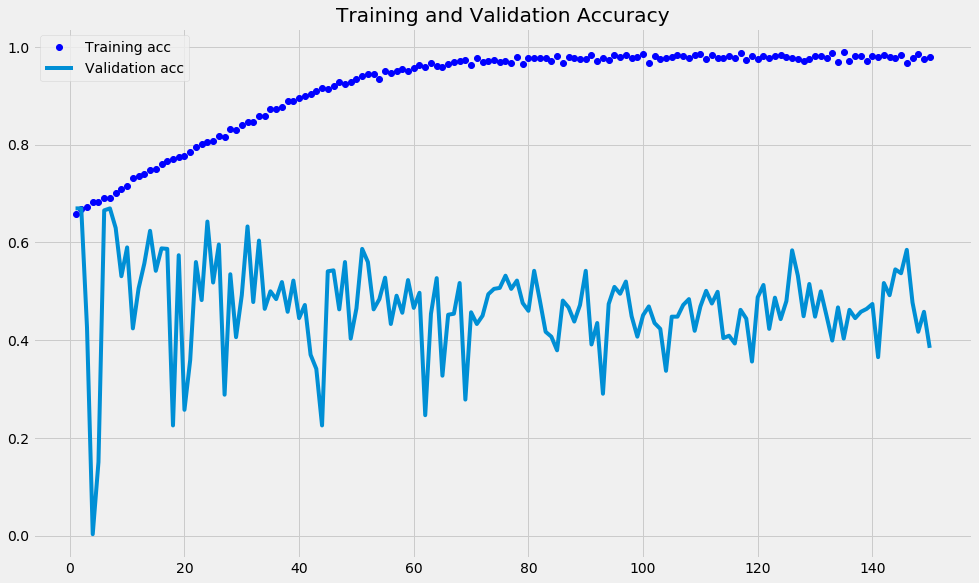

<Figure size 432x288 with 0 Axes>

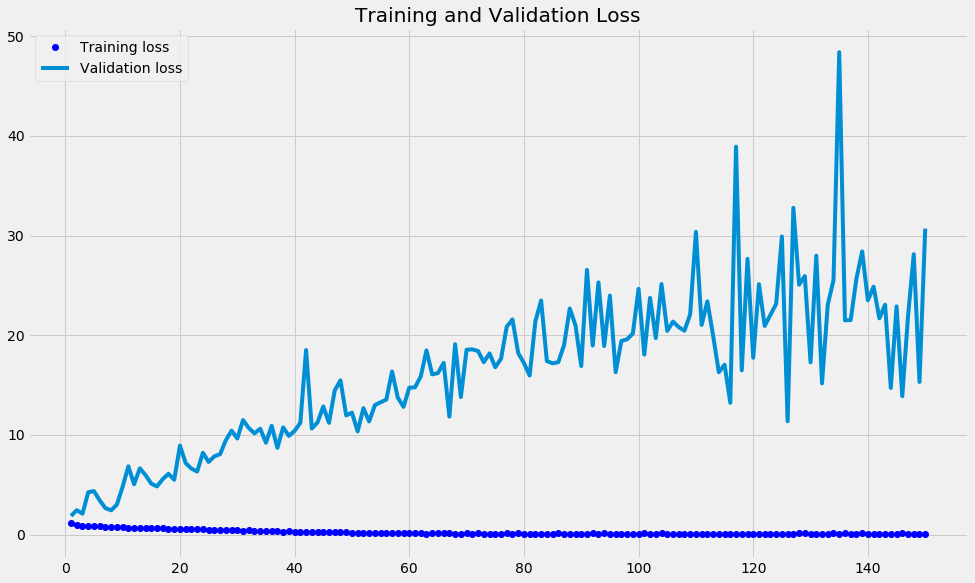

<Figure size 432x288 with 0 Axes>

In [354]:
fig = plt.figure(figsize=(15, 20))

accuracy = history_2.history['acc']
val_accuracy = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(15, 20))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

<p> Here, accuracy decreased compared to the baseline model and loss increased significantly. It performed well on the training data but didn't do good enough on validation dataset. But then again, class imbalance was not considered. For this images with higher resolution can be considered.</p>

In [355]:
# balancing class for images with higher resolution

metadata_image = metadata
metadata_image.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


In [356]:
# there is a class imbalance, 6,705 instances in melanocytic nevi

metadata_image.label.value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64

In [357]:
# feeding into model

X = metadata_image
y = metadata_image['label']


# resolving the issue of class imabalance using the random under sampler

rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)


# size of our X and y vairables after adjusting

print(X_resampled.shape)
print(y_resampled.shape)

print(X_resampled.iloc[0,:])


(805, 8)
(805,)
lesion_id        HAM_0002734
image_id        ISIC_0028190
dx                     akiec
dx_type                histo
age                       45
sex                     male
localization            face
label                      0
Name: 0, dtype: object


In [358]:
# checking the number of images in each class, our classes are now balanced

np.unique(y_resampled, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([115, 115, 115, 115, 115, 115, 115]))

In [359]:
# Assinging X, and y for model

image_ids = X_resampled.iloc[:,1]
y = y_resampled

In [360]:
# loading 805 images


image_array = []
num_images = 805
i=0


for ID in tqdm(image_ids):
    
    im = f'/Users/ragnar/Desktop/HAM10000_images_part_1/{ID}.jpg'
    im = np.asarray(imageio.imread(im))
    image_array.append(im)

    i +=1
    if i == num_images:
        break

 99%|█████████▉| 795/805 [00:09<00:00, 84.39it/s]


In [361]:
# reducing total intensity of each pixel to range 0 to 1 to reduce computation time

x_images = np.asarray(image_array) / 255
print(x_images.shape)
print(y.shape)

(805, 450, 600, 3)
(805,)


In [362]:
# Building the same baseline architecture we used earlier with the 28x28 images

cnn = Sequential()

cnn.add(MaxPool2D((4, 4), input_shape=(450, 600,3)))

cnn.add(Conv2D(32, (3, 3), strides = (3,3), padding ='same', activation='relu'))
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
cnn.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Dropout(0.40))
cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(7, activation='softmax'))

print(cnn.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_49 (MaxPooling (None, 112, 150, 3)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 38, 50, 32)        896       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 38, 50, 32)        9248      
_________________________________________________________________
dropout_18 (Dropout)         (None, 38, 50, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 38, 50, 64)        18496     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 38, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 19, 25, 64)      

In [363]:
# Complied Model

cnn.compile('rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history_3 = cnn.fit(
    x_images, to_categorical(y),
    epochs=150, batch_size=200,
    validation_split=0.1,
    verbose=1,
    callbacks=[ModelCheckpoint('skin-cancer.h5', save_best_only=True)]
)


Train on 724 samples, validate on 81 samples
Epoch 1/150
724/724 [==============================] - 25s 34ms/step - loss: 3.9112 - acc: 0.1685 - val_loss: 1.9671 - val_acc: 0.0000e+00
Epoch 2/150
724/724 [==============================] - 33s 46ms/step - loss: 1.9219 - acc: 0.1561 - val_loss: 2.0599 - val_acc: 0.0000e+00
Epoch 3/150
724/724 [==============================] - 31s 42ms/step - loss: 1.9032 - acc: 0.1464 - val_loss: 2.5246 - val_acc: 0.0000e+00
Epoch 4/150
724/724 [==============================] - 32s 45ms/step - loss: 1.8892 - acc: 0.1961 - val_loss: 2.4834 - val_acc: 0.0000e+00
Epoch 5/150
724/724 [==============================] - 31s 43ms/step - loss: 1.9026 - acc: 0.1865 - val_loss: 2.5329 - val_acc: 0.0000e+00
Epoch 6/150
724/724 [==============================] - 33s 45ms/step - loss: 1.9001 - acc: 0.2459 - val_loss: 3.1524 - val_acc: 0.0000e+00
Epoch 7/150
724/724 [==============================] - 33s 46ms/step - loss: 1.8861 - acc: 0.1878 - val_loss: 2.5768 - va

724/724 [==============================] - 31s 42ms/step - loss: 0.0225 - acc: 0.9945 - val_loss: 5.5882 - val_acc: 0.5556
Epoch 121/150
724/724 [==============================] - 32s 44ms/step - loss: 0.0228 - acc: 0.9945 - val_loss: 5.4262 - val_acc: 0.5802
Epoch 122/150
724/724 [==============================] - 33s 46ms/step - loss: 0.6125 - acc: 0.8508 - val_loss: 3.1402 - val_acc: 0.5802
Epoch 123/150
724/724 [==============================] - 32s 44ms/step - loss: 0.8750 - acc: 0.6989 - val_loss: 5.3001 - val_acc: 0.4321
Epoch 124/150
724/724 [==============================] - 34s 47ms/step - loss: 0.0874 - acc: 0.9834 - val_loss: 6.0619 - val_acc: 0.4568
Epoch 125/150
724/724 [==============================] - 35s 48ms/step - loss: 0.0350 - acc: 0.9917 - val_loss: 6.5436 - val_acc: 0.4198
Epoch 126/150
724/724 [==============================] - 33s 46ms/step - loss: 0.0184 - acc: 0.9972 - val_loss: 6.3084 - val_acc: 0.4444
Epoch 127/150
724/724 [==============================] 

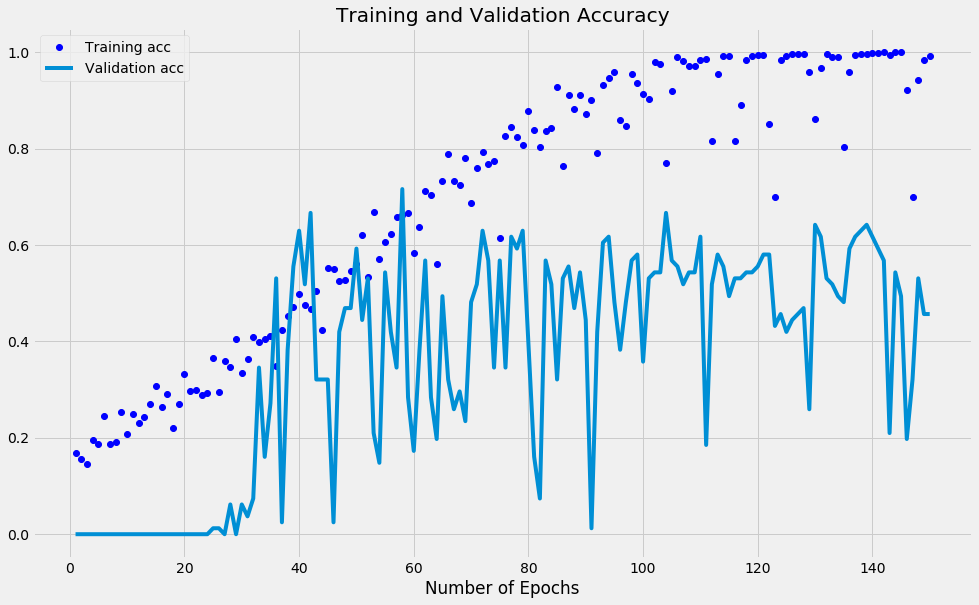

<Figure size 432x288 with 0 Axes>

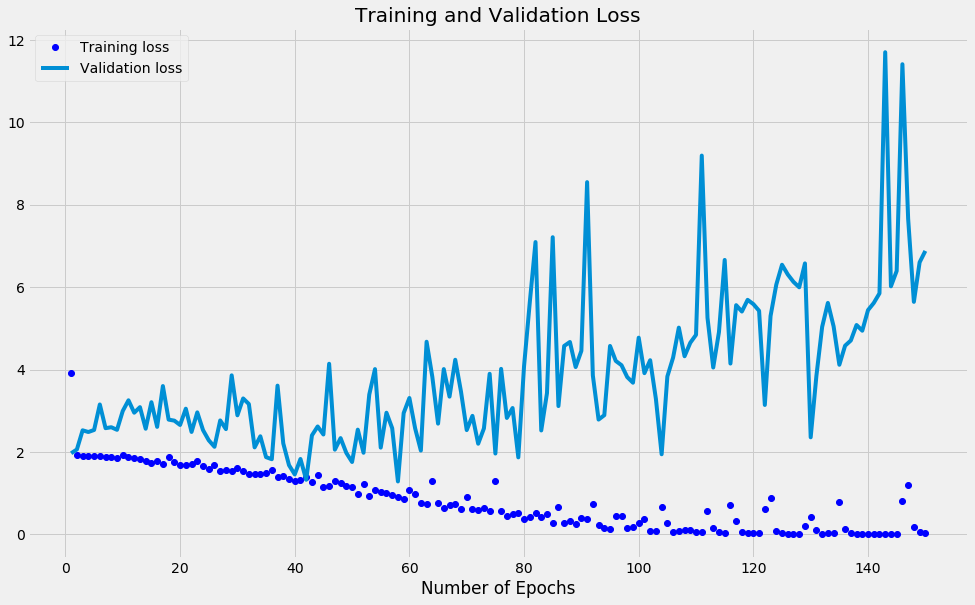

<Figure size 432x288 with 0 Axes>

In [364]:
fig = plt.figure(figsize=(15, 20))

accuracy = history_3.history['acc']
val_accuracy = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(15, 20))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

<p> This is more unstable than low resolutaion images and the loss function increased instead of decreasing. Model is overfit on training data. </p>

In [426]:
# standard scaling the pixels to reduce computation time

x_train_standard, x_test_standard, y_train_standard, y_test_standard = train_test_split(x_images, y, test_size=.3)
print(x_train_standard.shape)
print(x_test_standard.shape)
print(y_train_standard.shape)
print(y_test_standard.shape)

(563, 450, 600, 3)
(242, 450, 600, 3)
(563,)
(242,)


In [427]:
x_train_mean = np.mean(x_train_standard)
x_train_std = np.std(x_train_standard)
x_test_mean = np.mean(x_test_standard)
x_test_std = np.std(x_test_standard)

x_train_standard = (x_train_standard - x_train_mean) / x_train_std
x_test_standard = (x_test_standard - x_test_mean) / x_test_std


In [428]:
x_train_standard.shape


(563, 450, 600, 3)

In [429]:
x_test_standard.shape

(242, 450, 600, 3)

In [430]:
y_test_standard = to_categorical(y_test_standard, num_classes=7)
y_train_standard = to_categorical(y_train_standard, num_classes=7)

In [431]:
y_train_standard.shape

(563, 7)

In [432]:
y_test_standard.shape

(242, 7)

In [412]:
# image augmentation to reduce overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(x_train_standard)

In [378]:
# building an architecture with dropout layers to further reduce overfitting and increase stability of model

model_4 = Sequential()

model_4.add(MaxPool2D((4, 4), input_shape=(450, 600,3)))

model_4.add(Conv2D(32, (3, 3), padding ='same', activation='relu'))
model_4.add(Conv2D(32, (3, 3),  padding='same', activation='relu'))
model_4.add(MaxPool2D((2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
model_4.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
model_4.add(MaxPool2D((2, 2)))
model_4.add(Dropout(0.40))
model_4.add(Flatten())

model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(7, activation='softmax'))

print(model_4.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_51 (MaxPooling (None, 112, 150, 3)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 112, 150, 32)      896       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 112, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 56, 75, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 56, 75, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 56, 75, 64)        18496     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 56, 75, 64)      

In [423]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

In [424]:
# Complied Model

model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [433]:
history_4 = model_4.fit_generator(
    datagen.flow(x_train_standard, y_train_standard,batch_size=10),
    epochs=50,
    validation_data=(x_test_standard, y_test_standard),
    verbose=1,
    steps_per_epoch=x_train_standard.shape[0],
    callbacks=[ModelCheckpoint('skin-cancer-4.h5', save_best_only=True)]
)

Epoch 1/50
563/563 [==============================] - 379s 673ms/step - loss: 1.8984 - accuracy: 0.2045 - val_loss: 1.7801 - val_accuracy: 0.3182
Epoch 2/50
563/563 [==============================] - 336s 596ms/step - loss: 1.7445 - accuracy: 0.3040 - val_loss: 1.6420 - val_accuracy: 0.3843
Epoch 3/50
563/563 [==============================] - 336s 597ms/step - loss: 1.5850 - accuracy: 0.3806 - val_loss: 1.5279 - val_accuracy: 0.4504
Epoch 4/50
563/563 [==============================] - 340s 604ms/step - loss: 1.4456 - accuracy: 0.4381 - val_loss: 1.4840 - val_accuracy: 0.4545
Epoch 5/50
563/563 [==============================] - 335s 596ms/step - loss: 1.3993 - accuracy: 0.4642 - val_loss: 1.4314 - val_accuracy: 0.4380
Epoch 6/50
563/563 [==============================] - 336s 597ms/step - loss: 1.3185 - accuracy: 0.4868 - val_loss: 1.3869 - val_accuracy: 0.4835
Epoch 7/50
563/563 [==============================] - 339s 602ms/step - loss: 1.2606 - accuracy: 0.5182 - val_loss: 1.3921 -

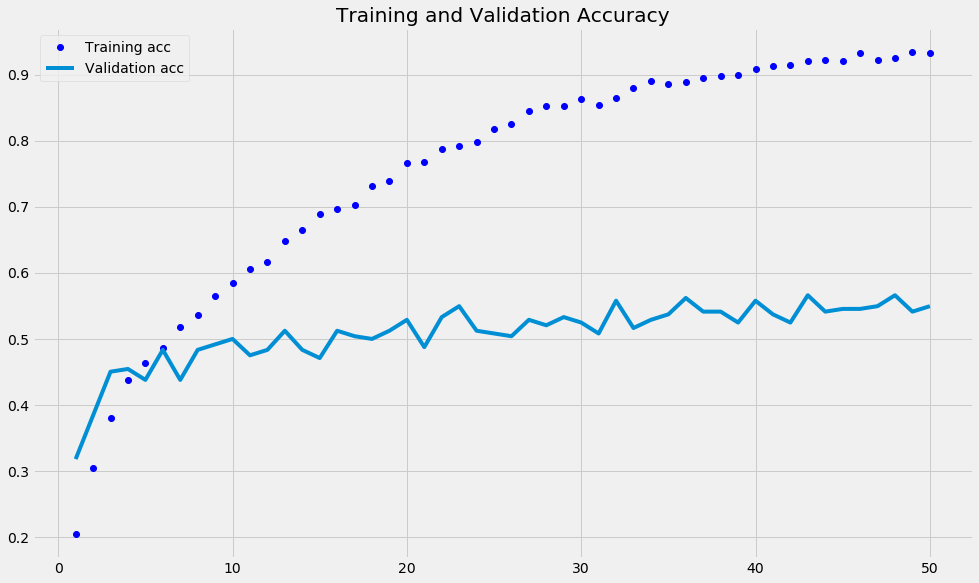

<Figure size 432x288 with 0 Axes>

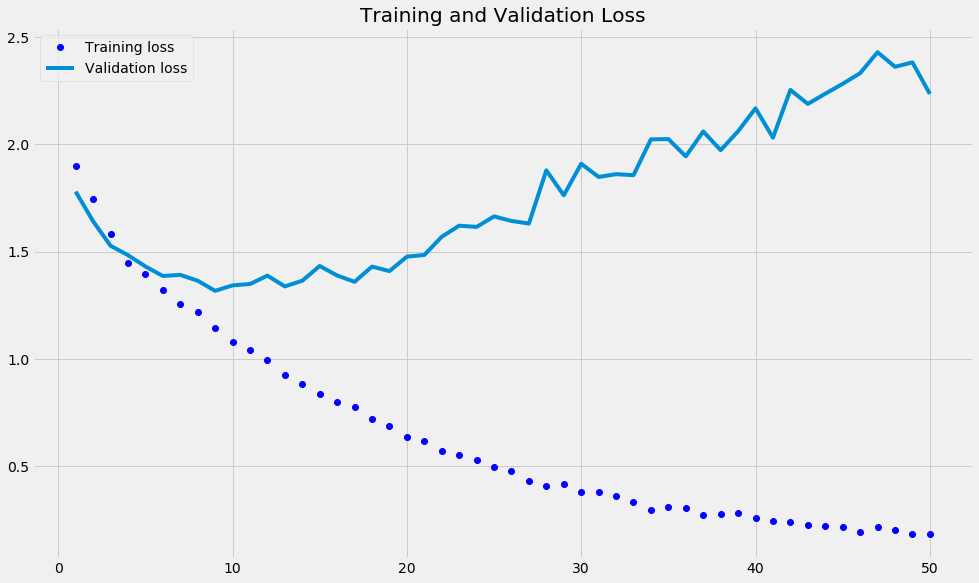

<Figure size 432x288 with 0 Axes>

In [435]:
fig = plt.figure(figsize=(15, 20))

accuracy = history_4.history['accuracy']
val_accuracy = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(15, 20))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

<h4>6. Key findings</h4>
<ol><li>Accuracy is higher if more lower resolution images is used rather than small number of high resolution images.</li>
    <li> Loss keep increasing in every model and optimizer couldn't do anything to keep it in the right track. </li>
    <li> For low resolution images, accuracy is highest but unstable.</li>
    <li>Loss in low resolution images is 1 to 2.5 but in higher resolution images it is 2 to 6. </li>
    <li>For lower resolution images everything was done on unscaled, imbalanced class after fixing this issue only 800 picture left to analyse in case of higher resolution images.</li>